In [171]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

import matplotlib.pyplot as plt
from PIL import Image

if torch.cuda.is_available():   #cuda가 사용가능한 지 확인
    torch.backends.cudnn.deterministic = True   #cudnn의 결정론적 모드를 활성화해서 동일한 입력에 대해 항상 동일한 결과를 보장.

In [172]:

#############
## SETTINGS
#############

#Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.01    #학습률 0.01
BATCH_SIZE = 128    #128장씩 학습
NUM_EPOCHS = 10     #10번의 반복

#Architecture
NUM_FEATURES = 32*32
NUM_CLASSES = 10

#Other
DEVICE =  "cuda:0"
'''cuda는 cuda를 사용하는 GPU를 의미한다.
즉, cuda:1은 두번째(0부터 시작)GPU를 뜻한다. 나의 노트북은 1개의 GPU를 사용하므로 cuda:1은 런타임에러가 뜬다'''

GRAYSCALE = True


In [173]:

###################
## MNIST DATASET
###################

'''데이터셋 및 데이터로더 설정'''
resize_transform = transforms.Compose([transforms.Resize((32, 32)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5), (0.5))
                                       ])


# Note transforms.ToTensor() scales input images
# to 0-1 range
train_dataset = datasets.MNIST(root='data',
                               train=True,
                               transform=resize_transform,
                               download=True)
test_dataset = datasets.MNIST(root='data',
                              train=False,
                              transform=resize_transform)
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break


Image batch dimensions: torch.Size([128, 1, 32, 32])
Image label dimensions: torch.Size([128])


In [174]:
device = torch.device(DEVICE)   #특정 GPU로 설정
torch.manual_seed(0)    #같은 난수를 생성하기 위한 시드 설정

for epoch in range(2):
    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])

        x = x.to(device)    #입력 데이터를 GPU로 이동시켜야함
        y = y.to(device)
        break


Epoch: 1 | Batch index: 0 | Batch size: 128
Epoch: 2 | Batch index: 0 | Batch size: 128


In [175]:

###################
## MODEL
###################

class LeNet5(nn.Module):
    def __init__(self, num_classes, grayscale=False):
        super(LeNet5, self).__init__()

        self.grayscale = grayscale
        self.num_classes = num_classes

        if self.grayscale:
            in_channels = 1
        else:
            in_channels = 3
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 6, kernel_size=5),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(16*5*5, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, num_classes)
        )

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

In [176]:

torch.manual_seed(RANDOM_SEED)

model = LeNet5(NUM_CLASSES, GRAYSCALE)
model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [177]:
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples*100

start_time = time.time()
for epoch in range(NUM_EPOCHS):

    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets) #손실함수
        optimizer.zero_grad()

        cost.backward()

        ### UPDATE MODEL PARAMETERS
        optimizer.step()

        ### LOGGING
        if not batch_idx % 50:
            print('EPOCH: %03d/%03d | Batch %04d/%04d | cost: %.4f'%(epoch+1, NUM_EPOCHS, batch_idx, len(train_loader), cost))

    
    model.eval()
    with torch.set_grad_enabled(False): #save memory during inference
        print('Epoch: %03d/%03d | Train: %.3f%%' % (epoch+1, NUM_EPOCHS, compute_accuracy(model, train_loader, device = DEVICE)))
    print('Time elapse: %.2f min' % ((time.time() - start_time)/60))

print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

EPOCH: 001/010 | Batch 0000/0469 | cost: 3.1557
EPOCH: 001/010 | Batch 0050/0469 | cost: 2.3002
EPOCH: 001/010 | Batch 0100/0469 | cost: 2.3106
EPOCH: 001/010 | Batch 0150/0469 | cost: 2.3097
EPOCH: 001/010 | Batch 0200/0469 | cost: 2.3226
EPOCH: 001/010 | Batch 0250/0469 | cost: 2.2949
EPOCH: 001/010 | Batch 0300/0469 | cost: 2.3178
EPOCH: 001/010 | Batch 0350/0469 | cost: 2.3073
EPOCH: 001/010 | Batch 0400/0469 | cost: 2.2970
EPOCH: 001/010 | Batch 0450/0469 | cost: 2.3104
Epoch: 001/010 | Train: 10.442%
Time elapse: 0.52 min
EPOCH: 002/010 | Batch 0000/0469 | cost: 2.3032
EPOCH: 002/010 | Batch 0050/0469 | cost: 2.3057
EPOCH: 002/010 | Batch 0100/0469 | cost: 2.2980
EPOCH: 002/010 | Batch 0150/0469 | cost: 2.2983
EPOCH: 002/010 | Batch 0200/0469 | cost: 2.2992
EPOCH: 002/010 | Batch 0250/0469 | cost: 2.2978
EPOCH: 002/010 | Batch 0300/0469 | cost: 2.3084
EPOCH: 002/010 | Batch 0350/0469 | cost: 2.3027
EPOCH: 002/010 | Batch 0400/0469 | cost: 2.3066
EPOCH: 002/010 | Batch 0450/0469 |

KeyboardInterrupt: 

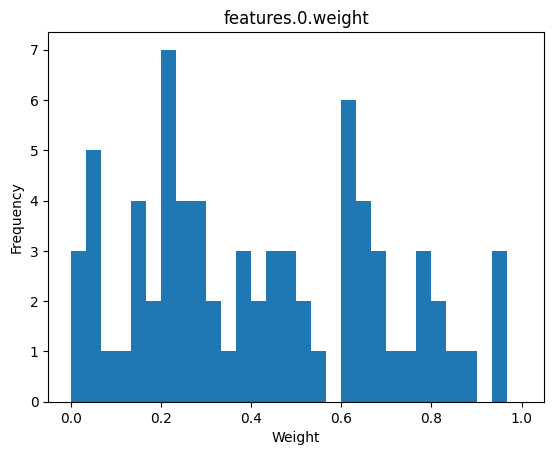

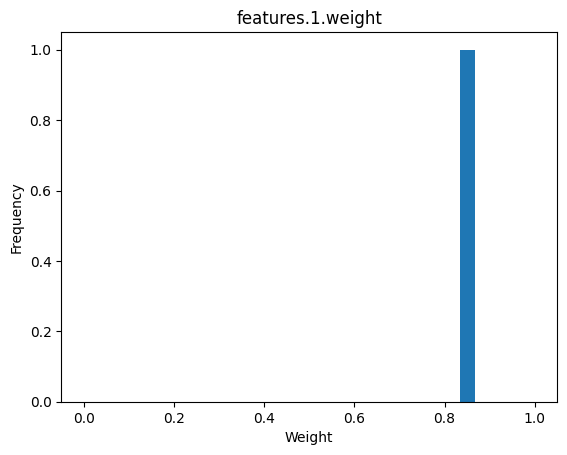

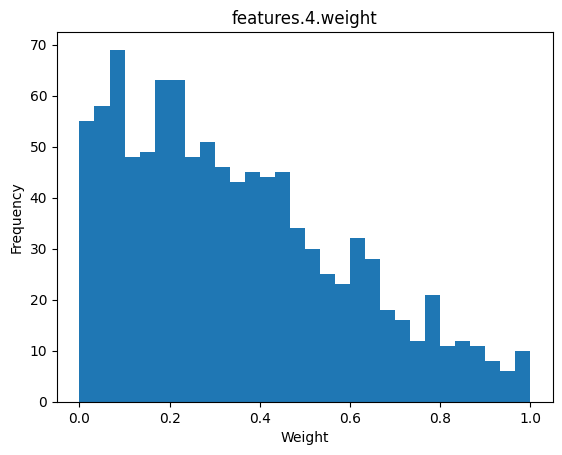

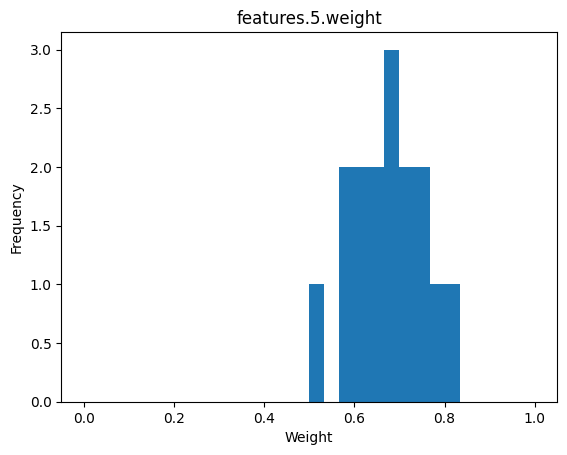

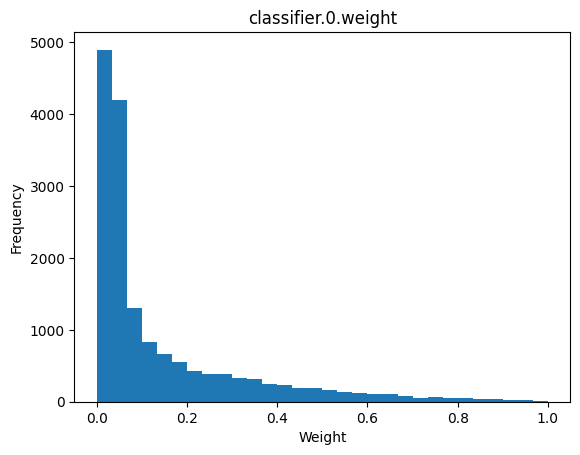

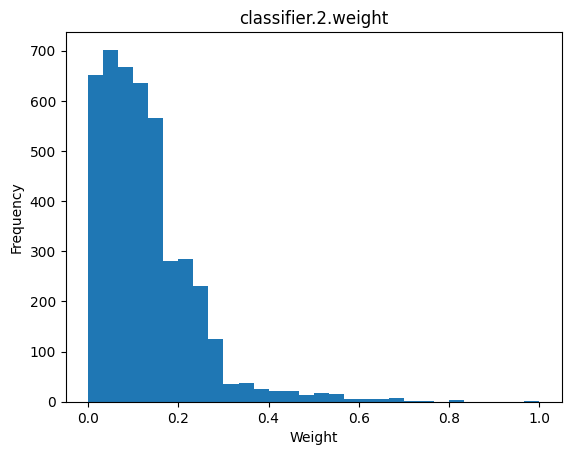

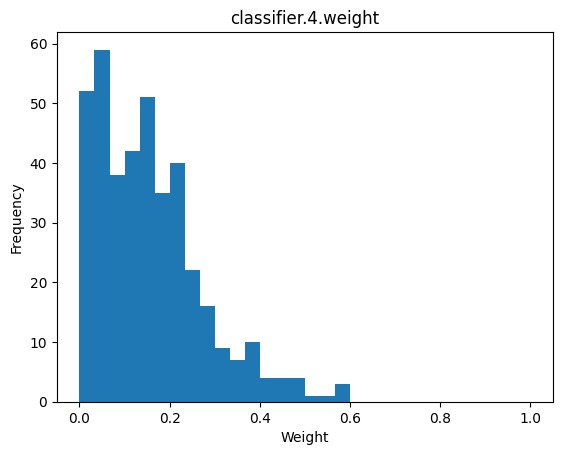

In [ ]:
def plot_weight_distribution(layer, layer_name):
    weights = layer.detach().cpu().numpy()
    plt.hist(weights.flatten(), 30, range=(0, 1))
    plt.title(layer_name)
    plt.xlabel('Weight')
    plt.ylabel('Frequency')
    plt.show()

for name, param in model.named_parameters():
    if 'weight' in name:
        plot_weight_distribution(param, name)

In [ ]:
with torch.set_grad_enabled(False): #save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader, device = DEVICE)))

Test accuracy: 98.97%


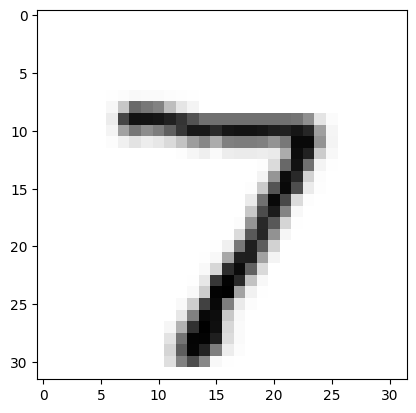

In [ ]:
for batch_idx, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets
    break
nhwc_img = np.transpose(features[0], axes=(1, 2, 0))
nhw_img = np.squeeze(nhwc_img.numpy(), axis=2)
plt.imshow(nhw_img, cmap='Greys')

In [ ]:
model.eval()
logits, probas = model(features.to(device)[0, None])
print('Probability 7 %.2f%%'% (probas[0][7]*100))   #probas는 출력층의 7번째 인덱스에서의 확률을 나타냄 즉, 7일 확률

Probability 7 100.00%
